In [63]:
import numpy as np
import matplotlib.pyplot as plt

In [64]:
import msise00
from datetime import datetime
from scipy.interpolate import interp1d

In [65]:
glat = 0.0
glon = 0.0
alt_km = np.arange(0.0, 2110, 20.0)
time = datetime(2013, 12, 13, 13, 0, 0)

atmos = msise00.run(time, alt_km, glat, glon)

ATM_height = atmos.alt_km
ATM_density= atmos.Total[0,:,0,0]

In [66]:
atmos = msise00.run(time, alt_km, glat, glon)


ATM_height = atmos.alt_km
ATM_density= atmos.Total[0,:,0,0]

density_int   = interp1d(ATM_height*1E3, ATM_density, kind='linear', fill_value=100.0, bounds_error=False)

In [67]:
import iri2016.altitude as iri

sim=iri.main(time, (200.0, 2110, 20.0), 0, 0)

alt_arr    = sim['alt_km']
nO_arr     = sim['nO+']
nH_arr     = sim['nH+']

mass_density = (sim['nO+']*16+sim['nH+']*1.0)*1.67E-27

mass_density_int = interp1d(alt_arr*1E3, mass_density, kind='linear', fill_value=0.0, bounds_error=False)

In [68]:
def compute_rho(altitude):
    return float(density_int(altitude))

In [69]:
def compute_mass_dens(altitude):
    return float(mass_density_int(altitude))

In [70]:
def compute_L(Md, rho, v):
    
    return np.power(4*np.pi*1E-7*Md**2/(4*np.pi**2*rho*v**2), 1.0/6.0)

In [71]:
def compute_D(altitude, v, S, CD):
    rho = compute_rho(altitude)
    D = 0.5*rho*v**2*S*CD
    
    if altitude < 0:
        D = 1E2
    
    return D

In [72]:
def compute_mhd_drag(altitude, v, Md, CD):
    rho = compute_mass_dens(altitude)
    
    L   = compute_L(Md, rho, v)
    S   = np.pi*L**2
    
    D   = 0.5*rho*v**2*S*CD
    
    return D

In [73]:
g0 = 9.80665
rP = 6375E3

def compute_g(altitude):
    
    r = altitude + rP
    
    g0 = 3.986E14/(rP**2)
    
    g = g0*(rP/r)**2
    
    if altitude < 0:
        g = 9.80665
        
    return g

In [74]:
from scipy.integrate import odeint

In [75]:
def circularSpeed(altitude):
    
    return np.sqrt(3.986E14/(rP + altitude))

In [76]:
def EOM1(y,t,S,CD,m):
    
    r, v, gamma  = y
    
    D            = compute_D(r - rP, v, S, CD)
    g            = compute_g(r - rP)
    
    dydt         = [v*np.sin(gamma),
                    -1*D/m - 1*g*np.sin(gamma),
                    -1*g*np.cos(gamma)/v + v*np.cos(gamma)/r]
    
    return dydt
    

def solveTrajectory1(r0, v0, gamma0, t_sec, N, tol, S, CD, m):
    
    x0        = [r0, v0, gamma0]
    t         = np.linspace(0, t_sec, N) 
    
    xbar      = odeint(EOM1, x0, t ,rtol=tol, atol=tol, args=(S, CD, m))
    
    r         = xbar[:,0]
    v         = xbar[:,1]
    gamma     = xbar[:,2]
    
    return t, r, v, gamma

def EOM2(y,t,S,Md,CD1,CD2,m):
    
    r, v, gamma  = y
    
    D1            = compute_D(r - rP, v, S, CD1)
    D2            = compute_mhd_drag(r-rP, v, Md, CD2)*0.3
    
    D = D1 + D2
    
    g            = compute_g(r - rP)
    
    dydt         = [v*np.sin(gamma),
                    -1*D/m - 1*g*np.sin(gamma),
                    -1*g*np.cos(gamma)/v + v*np.cos(gamma)/r]
    
    return dydt


def solveTrajectory2(r0, v0, gamma0, t_sec, N, tol, S, Md, CD1, CD2, m):
    
    x0        = [r0, v0, gamma0]
    t         = np.linspace(0, t_sec, N) 
    
    xbar      = odeint(EOM2, x0, t ,rtol=tol, atol=tol, args=(S, Md, CD1, CD2, m))
    
    r         = xbar[:,0]
    v         = xbar[:,1]
    gamma     = xbar[:,2]
    
    return t, r, v, gamma

In [77]:
100*np.pi*(10.0/2)**2

7853.981633974483

In [78]:
np.pi*(10/2)**2

78.53981633974483

In [88]:


t0, r0, v0, gamma0 = solveTrajectory1(rP+800E3, circularSpeed(800E3), 0.0, 100.91*365*86400, 10001, 1E-6, 1.0, 2.2, 100.0)
t1, r1, v1, gamma1 = solveTrajectory1(rP+800E3, circularSpeed(800E3), 0.0, 15.67*365*86400, 10001, 1E-6, 78.54, 2.2, 100.0)
t2, r2, v2, gamma2 = solveTrajectory2(rP+800E3, circularSpeed(800E3), 0.0, 60.0*365*86400, 10001, 1E-6, 1.0, 7854, 2.2, 3.6, 100.0)

<ipython-input-70-fc0b228894be>:3: RuntimeWarning: divide by zero encountered in double_scalars
  return np.power(4*np.pi*1E-7*Md**2/(4*np.pi**2*rho*v**2), 1.0/6.0)
<ipython-input-72-ad58fd8f027d>:7: RuntimeWarning: invalid value encountered in double_scalars
  D   = 0.5*rho*v**2*S*CD


In [90]:


t3, r3, v3, gamma3 = solveTrajectory1(rP+1000E3, circularSpeed(1000E3), 0.0, 100.986*365*86400, 10001, 1E-6, 1.0, 2.2, 100.0)
t4, r4, v4, gamma4 = solveTrajectory1(rP+1000E3, circularSpeed(1000E3), 0.0, 100*365*86400, 10001, 1E-6, 78.54, 2.2, 100.0)
t5, r5, v5, gamma5 = solveTrajectory2(rP+1000E3, circularSpeed(1000E3), 0.0, 100*365*86400, 10001, 1E-6, 1.0, 7854, 2.2, 3.6, 100.0)

<ipython-input-70-fc0b228894be>:3: RuntimeWarning: divide by zero encountered in double_scalars
  return np.power(4*np.pi*1E-7*Md**2/(4*np.pi**2*rho*v**2), 1.0/6.0)
<ipython-input-72-ad58fd8f027d>:7: RuntimeWarning: invalid value encountered in double_scalars
  D   = 0.5*rho*v**2*S*CD


In [93]:


t6, r6, v6, gamma6 = solveTrajectory1(rP+1200E3, circularSpeed(1200E3), 0.0, 100.986*365*86400, 10001, 1E-6, 1.0, 2.2, 100.0)
t7, r7, v7, gamma7 = solveTrajectory1(rP+1200E3, circularSpeed(1200E3), 0.0, 100.986*365*86400, 10001, 1E-6, 78.54, 2.2, 100.0)
t8, r8, v8, gamma8 = solveTrajectory2(rP+1200E3, circularSpeed(1200E3), 0.0, 100.996*365*86400, 10001, 1E-6, 1.0, 7854, 2.2, 3.6, 100.0)

<ipython-input-70-fc0b228894be>:3: RuntimeWarning: divide by zero encountered in double_scalars
  return np.power(4*np.pi*1E-7*Md**2/(4*np.pi**2*rho*v**2), 1.0/6.0)
<ipython-input-72-ad58fd8f027d>:7: RuntimeWarning: invalid value encountered in double_scalars
  D   = 0.5*rho*v**2*S*CD


In [94]:


t9, r9, v9, gamma9 = solveTrajectory1(rP+1400E3, circularSpeed(1400E3), 0.0, 100.986*365*86400, 10001, 1E-6, 1.0, 2.2, 100.0)
t10, r10, v10, gamma10 = solveTrajectory1(rP+1400E3, circularSpeed(1400E3), 0.0, 100.986*365*86400, 10001, 1E-6, 78.54, 2.2, 100.0)
t11, r11, v11, gamma11 = solveTrajectory2(rP+1400E3, circularSpeed(1400E3), 0.0, 100*365*86400, 10001, 1E-6, 1.0, 7854, 2.2, 3.6, 100.0)

<ipython-input-70-fc0b228894be>:3: RuntimeWarning: divide by zero encountered in double_scalars
  return np.power(4*np.pi*1E-7*Md**2/(4*np.pi**2*rho*v**2), 1.0/6.0)
<ipython-input-72-ad58fd8f027d>:7: RuntimeWarning: invalid value encountered in double_scalars
  D   = 0.5*rho*v**2*S*CD


In [83]:


t12, r12, v12, gamma12 = solveTrajectory1(rP+600E3, circularSpeed(600E3), 0.0, 10.0*365*86400, 10001, 1E-6, 1.0, 2.2, 100.0)
t13, r13, v13, gamma13 = solveTrajectory1(rP+600E3, circularSpeed(600E3), 0.0, 0.1*365*86400, 10001, 1E-6, 78.54 , 2.2, 100.0)
t14, r14, v14, gamma14 = solveTrajectory2(rP+600E3, circularSpeed(600E3), 0.0, 5.996*365*86400, 10001, 1E-6, 1.0, 7854,2.2, 3.6, 100.0)

<ipython-input-70-fc0b228894be>:3: RuntimeWarning: divide by zero encountered in double_scalars
  return np.power(4*np.pi*1E-7*Md**2/(4*np.pi**2*rho*v**2), 1.0/6.0)
<ipython-input-72-ad58fd8f027d>:7: RuntimeWarning: invalid value encountered in double_scalars
  D   = 0.5*rho*v**2*S*CD


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


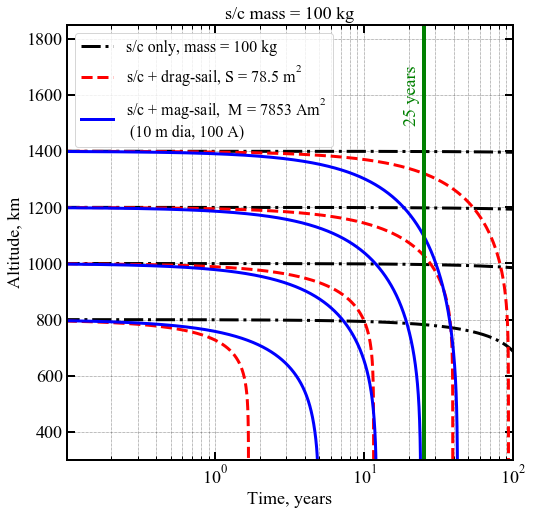

In [96]:
plt.figure(figsize=(8,8))
plt.rc('font',family='Times New Roman')
params = {'mathtext.default': 'regular' }
plt.rcParams.update(params)


plt.plot(t0/(365*86400),(r0-rP)/1E3, linestyle='dashdot', linewidth=3.0, color='k', label='s/c only, mass = 100 kg')
plt.plot(t1/(365*86400),(r1-rP)/1E3, linestyle='dashed', linewidth=3.0, color='r', label='s/c + drag-sail, S = 78.5 '+r'$m^2$')
plt.plot(t2/(365*86400),(r2-rP)/1E3, linestyle='solid',  linewidth=3.0, color='b', label='s/c + mag-sail,  M = 7853 '+r'$Am^2$'+'\n (10 m dia, 100 A)')


plt.plot(t3/(365*86400),(r3-rP)/1E3, linestyle='dashdot', linewidth=3.0, color='k')
plt.plot(t4/(365*86400),(r4-rP)/1E3, linestyle='dashed', linewidth=3.0, color='r')
plt.plot(t5/(365*86400),(r5-rP)/1E3, linestyle='solid',  linewidth=3.0, color='b')


plt.plot(t6/(365*86400),(r6-rP)/1E3, linestyle='dashdot', linewidth=3.0, color='k')
plt.plot(t7/(365*86400),(r7-rP)/1E3, linestyle='dashed', linewidth=3.0, color='r')
plt.plot(t8/(365*86400),(r8-rP)/1E3, linestyle='solid',  linewidth=3.0, color='b')


plt.plot(t9/(365*86400),(r9-rP)/1E3, linestyle='dashdot', linewidth=3.0, color='k')
plt.plot(t10/(365*86400),(r10-rP)/1E3, linestyle='dashed', linewidth=3.0, color='r')
plt.plot(t11/(365*86400),(r11-rP)/1E3, linestyle='solid',  linewidth=3.0, color='b')

ax = plt.gca()
ax.set_xscale('log')

ax.tick_params(direction='in')
ax.yaxis.set_ticks_position('both')

ax.xaxis.set_ticks_position('both')
ax.tick_params(axis='x',labelsize=18)
ax.tick_params(axis='y',labelsize=18)


ax.xaxis.set_tick_params(direction='in', which='both')


ax.yaxis.set_tick_params(direction='in', which='both')

ax.xaxis.set_tick_params(width=2, length=8)
ax.yaxis.set_tick_params(width=2, length=8)

ax.xaxis.set_tick_params(width=1, length=4, which='minor')
ax.yaxis.set_tick_params(width=1, length=4, which='minor')


ax.xaxis.grid(which='major', color='k', linestyle='dotted', linewidth=0.5)
ax.xaxis.grid(which='minor', color='k', linestyle='dotted', linewidth=0.5)

ax.yaxis.grid(which='major', color='k', linestyle='dotted', linewidth=0.5)
ax.yaxis.grid(which='minor', color='k', linestyle='dotted', linewidth=0.0)

plt.xlabel('Time, years', fontsize=18)
plt.ylabel('Altitude, km', fontsize=18)


plt.xlim([1.001E-1, 1E2])
plt.ylim([300.0, 1850.0])

plt.axvline(x=25,linestyle='solid', linewidth=4.0, color='g')
plt.text(21.0, 1600.0, '25 years', color='g', fontsize=18, va='center', ha='center', rotation=90)

plt.legend(loc='upper left', fontsize=16)
plt.title('s/c mass = 100 kg', fontsize=18)

for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(2)
    
plt.savefig('../new_plots/orbit-decay-03-sc-m=100kg-100A-10m-dia.png', dpi=300,bbox_inches='tight')
plt.savefig('../new_plots/orbit-decay-03-sc-m=100kg-100A-10m-dia.pdf', dpi=300,bbox_inches='tight')
plt.savefig('../new_plots/orbit-decay-03-sc-m=100kg-100A-10m-dia.eps', dpi=300,bbox_inches='tight')